# Prediction of the function development using RNNs and its comparsion with other NNs

In this work I would like to use various neural network models to predict future price of BTC based on various cryptocurrency prices.  

### Importing libraries

I am going to use tensorflow and other libraries.

In [1]:
# disable gpu
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow as tf

## Uncomment w
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
import glob

In [4]:
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = False

#### parameters

In [5]:
RATIO_TO_PREDICT = "BTC-USD"
FUTURE_PERIOD_PREDICT = 2

## Loading data

#### Downloaded data
I downloaded dataset from: https://pythonprogramming.net/static/downloads/machine-learning-data/crypto_data.zip. It contains 4 separate files with 5 columns for BTC, LTC, ETH and BCH. I am going to use only close price column. Code below extracts mecessary data from those files and creates pandas dataframe from it.

This code loops through ratios and loads the whole file into dataframe. Before adding that dataframe to our main dataframe which is called main_df we will drop unnecessary and only keep close price.

In [6]:
main_df = pd.DataFrame()

ratios = ["BTC-USD", "LTC-USD","ETH-USD","BCH-USD"]

for ratio in ratios:
    dataset = "crypto_data/"+ratio+".csv"
    df = pd.read_csv(dataset, names=["time","low","high","open","close","volume"])
    
    df.rename(columns={"close": f"{ratio}_close"}, inplace=True)
    
    df.set_index("time", inplace=True)
    df = df[[f"{ratio}_close"]]
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df)


In [7]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97724 entries, 1528968660 to 1535215200
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC-USD_close  97724 non-null  float64
 1   LTC-USD_close  96495 non-null  float64
 2   ETH-USD_close  97422 non-null  float64
 3   BCH-USD_close  87103 non-null  float64
dtypes: float64(4)
memory usage: 6.2 MB


In [8]:
main_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,97724.000000,96495.000000,97422.000000,87103.000000
mean,6773.521546,77.699971,424.308210,723.205108
std,641.354134,12.689494,75.786805,111.495463
min,5778.109863,49.560001,251.000000,473.209991
25%,6341.470215,74.010002,407.059998,686.750000
50%,6536.375000,80.680000,451.450012,742.380005
75%,7286.490112,84.730003,472.070007,810.404999
max,8482.799805,103.040001,547.000000,927.000000


Because there are some NaN values we will get rid of them using code below.

In [9]:
main_df = main_df.dropna()

Here we can see how main_df. It contains 5 columns from which we will be using only close prices.

In [10]:
main_df

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
time,,,,
1528968720,6487.379883,96.660004,486.010010,870.859985
1528968780,6479.410156,96.570000,486.000000,870.099976
1528968840,6479.410156,96.500000,485.750000,870.789978
1528968900,6479.979980,96.389999,486.000000,870.000000
1528968960,6480.000000,96.519997,486.000000,869.989990
...,...,...,...,...
1535214960,6713.140137,58.020000,279.359985,531.479980
1535215020,6714.520020,58.009998,279.359985,531.479980
1535215080,6714.520020,58.020000,279.369995,531.469971


To have better idea what our main dataframe represents we can plot our 4 prices using matplotlib

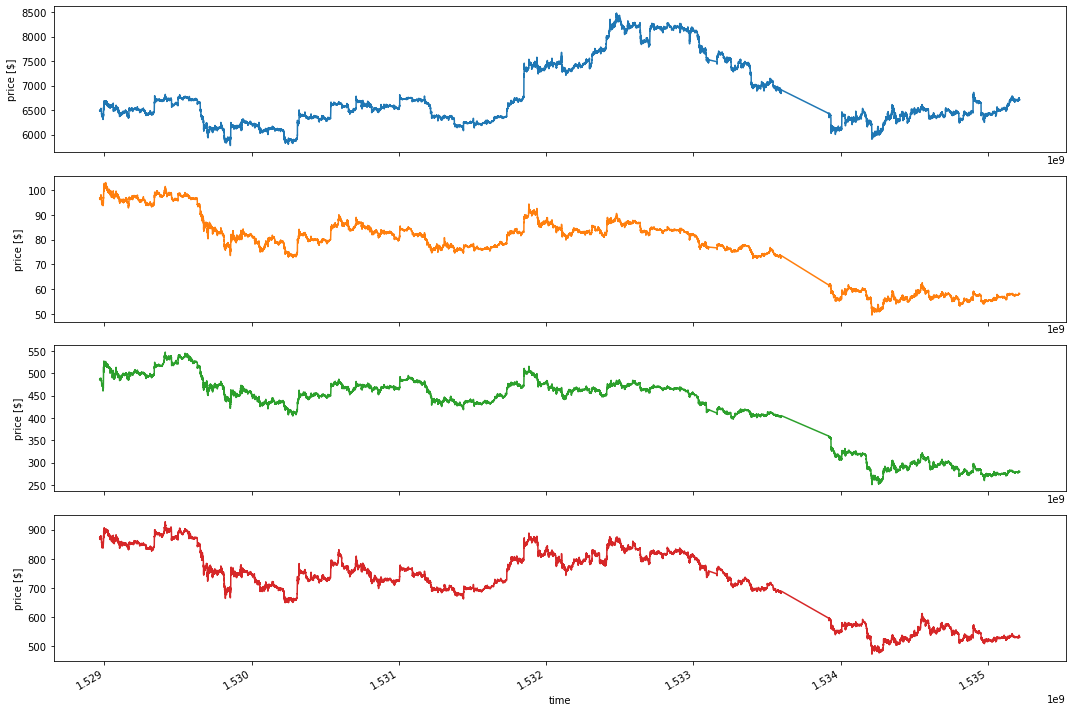

In [11]:
main_df.plot(subplots=True, legend = False, xlabel="time", ylabel="price [$]")
plt.tight_layout()
plt.show()

As we can see, there is a problematic part in our df in two thirds of the lenght.
I will cut the dataframe to exclude that data.

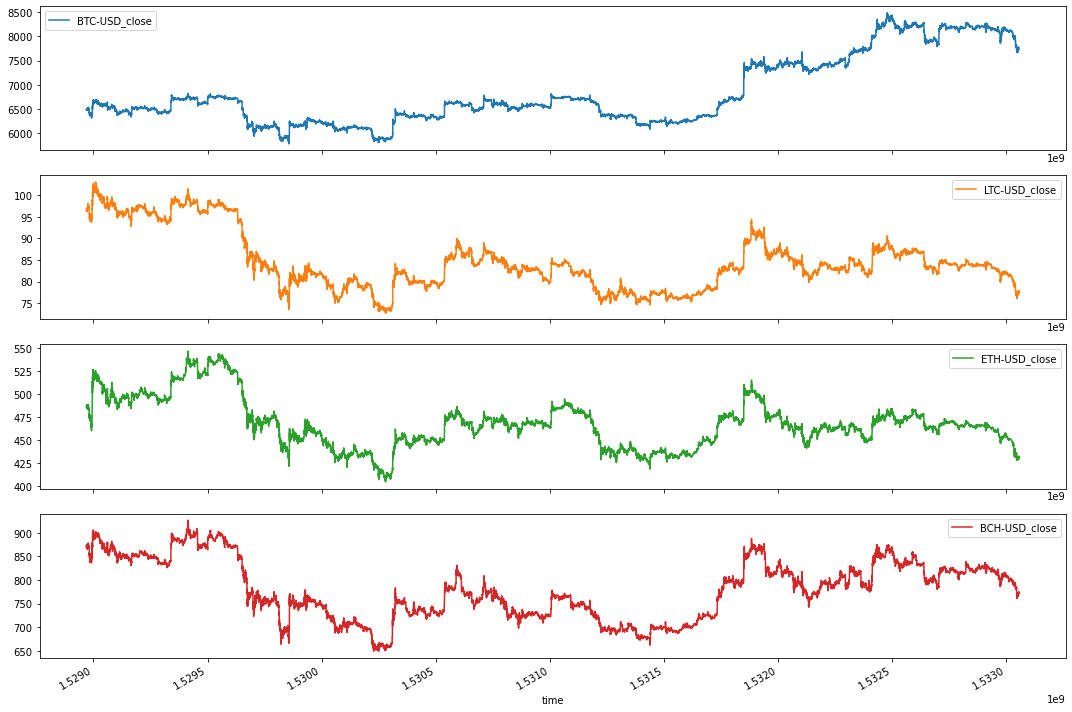

In [12]:
n = int(len(main_df)*0.70)
main_df = main_df[:n]
main_df.plot(subplots=True)
#main_df.fillna(method="ffill", inplace=True)
plt.tight_layout()
plt.show()

Another very useful function to use when exploring datasets is describe().

In [13]:
main_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,60281.000000,60281.000000,60281.000000,60281.000000
mean,6820.147480,84.659846,467.844925,780.026503
std,698.026359,6.660242,26.888865,63.047975
min,5778.109863,72.760002,404.220001,649.619995
25%,6330.399902,80.059998,449.600006,726.739990
50%,6591.540039,83.339996,466.250000,777.140015
75%,7374.970215,87.010002,478.700012,831.000000
max,8482.799805,103.040001,547.000000,927.000000


Some more info with .info()

In [14]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60281 entries, 1528968720 to 1533055140
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC-USD_close  60281 non-null  float64
 1   LTC-USD_close  60281 non-null  float64
 2   ETH-USD_close  60281 non-null  float64
 3   BCH-USD_close  60281 non-null  float64
dtypes: float64(4)
memory usage: 2.3 MB


#### Created data

This part explores data  I have been collecting.

In [15]:
path = 'crypto_data/my_dataset_csv.csv'               

my_df = pd.read_csv(path)  
my_df.fillna(method="ffill", inplace=True)

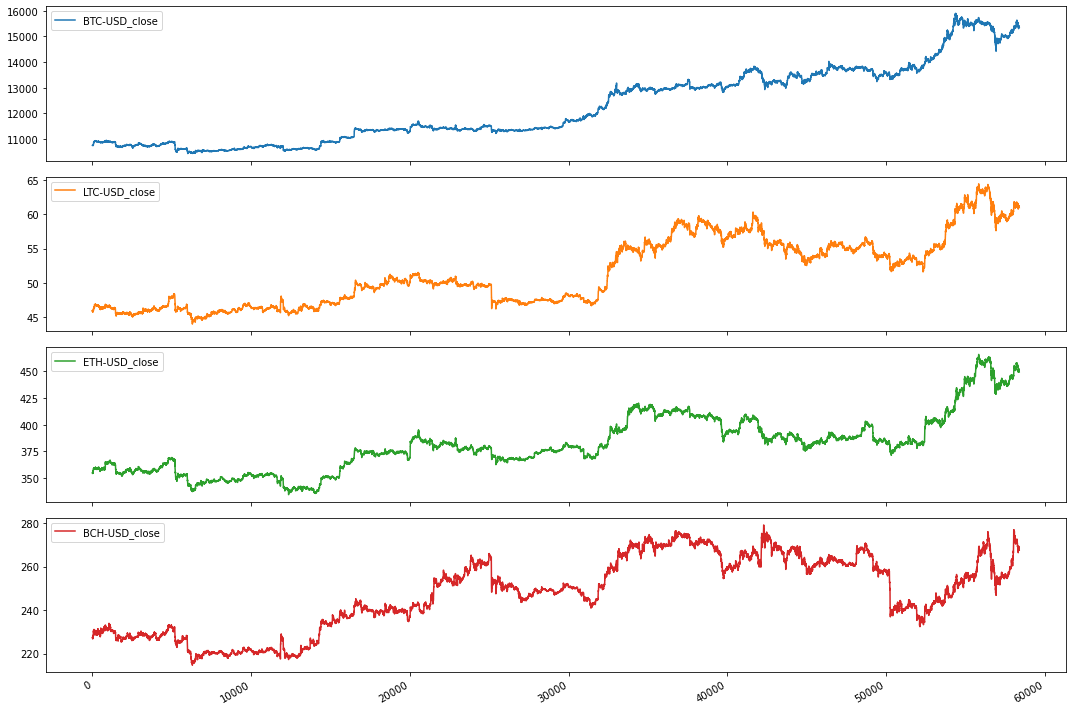

In [16]:
my_df.plot(subplots=True)
plt.tight_layout()
plt.show()

In [17]:
my_df = my_df.drop('Datetime', 1)

In [18]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58393 entries, 0 to 58392
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC-USD_close  58393 non-null  float64
 1   LTC-USD_close  58393 non-null  float64
 2   ETH-USD_close  58393 non-null  float64
 3   BCH-USD_close  58393 non-null  float64
dtypes: float64(4)
memory usage: 1.8 MB


In [19]:
my_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,58393.000000,58393.000000,58393.000000,58393.000000
mean,12268.990620,51.514071,381.585928,247.550386
std,1457.786256,4.955799,26.543030,16.886831
min,10440.311520,44.019604,334.545563,214.629974
25%,10901.831050,46.996445,363.054962,233.423035
50%,11552.742190,50.106308,379.235748,249.369400
75%,13433.404300,55.417450,394.844269,261.914581
max,15903.437500,64.402084,465.675476,279.121887


#### Data from binance

Data obtained from binance

In [20]:
binance_df = pd.DataFrame()

binance_symbols = ["BTCBUSD", "ETHBUSD", "XRPBUSD", "BCHBUSD", "LTCBUSD", "XLMBUSD", "ADABUSD"]

for ratio in binance_symbols:
    
    dataset = "crypto_data/old_data/"+ratio+"-1m-data.csv"
    df = pd.read_csv(dataset, index_col="timestamp")
    df.rename(columns={"close": f"{ratio}_close"}, inplace=True)

    df = df[[f"{ratio}_close"]]
    df = df[:568700]
    
    
    if len(binance_df) == 0:
        binance_df = df
    else:
        binance_df = binance_df.join(df, on='timestamp')

XRP has a bad correlation with other data that is why I will drop it

In [21]:
binance_df = binance_df.drop('XRPBUSD_close', 1) 

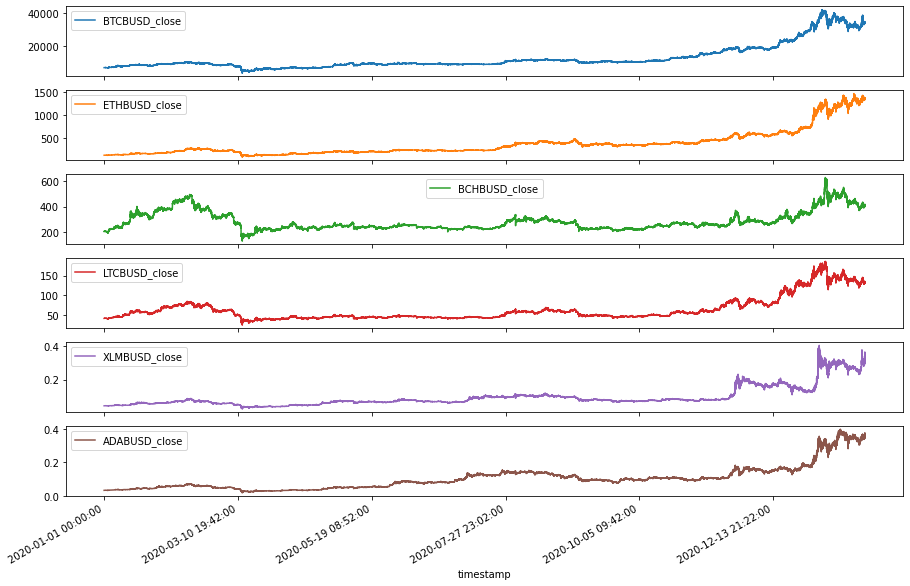

In [22]:
binance_df.plot(subplots=True)
plt.show()

In [633]:
binance_df.index

Index(['2020-01-01 00:00:00', '2020-01-01 00:01:00', '2020-01-01 00:02:00',
       '2020-01-01 00:03:00', '2020-01-01 00:04:00', '2020-01-01 00:05:00',
       '2020-01-01 00:06:00', '2020-01-01 00:07:00', '2020-01-01 00:08:00',
       '2020-01-01 00:09:00',
       ...
       '2021-01-30 19:03:00', '2021-01-30 19:04:00', '2021-01-30 19:05:00',
       '2021-01-30 19:06:00', '2021-01-30 19:07:00', '2021-01-30 19:08:00',
       '2021-01-30 19:09:00', '2021-01-30 19:10:00', '2021-01-30 19:11:00',
       '2021-01-30 19:12:00'],
      dtype='object', name='timestamp', length=568700)

#### Convert to percentage change

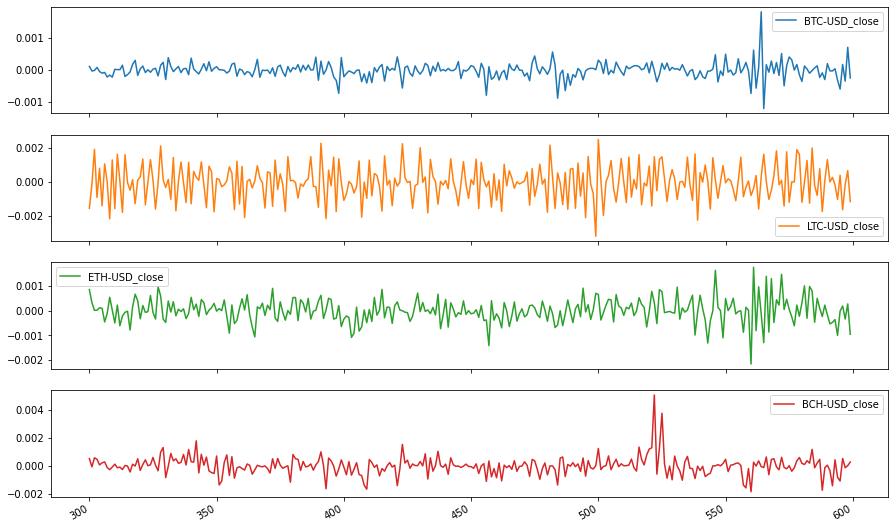

In [23]:

my_df = my_df.pct_change().copy()  #!!!
my_df[300:600].plot(subplots=True)
my_df = my_df[1:]
plt.show()


<AxesSubplot:>

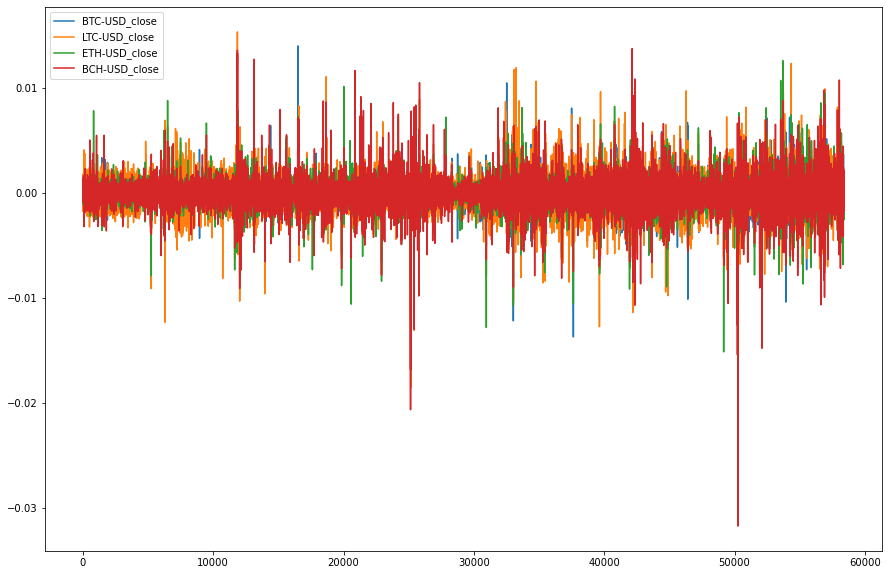

In [24]:
my_df.plot()

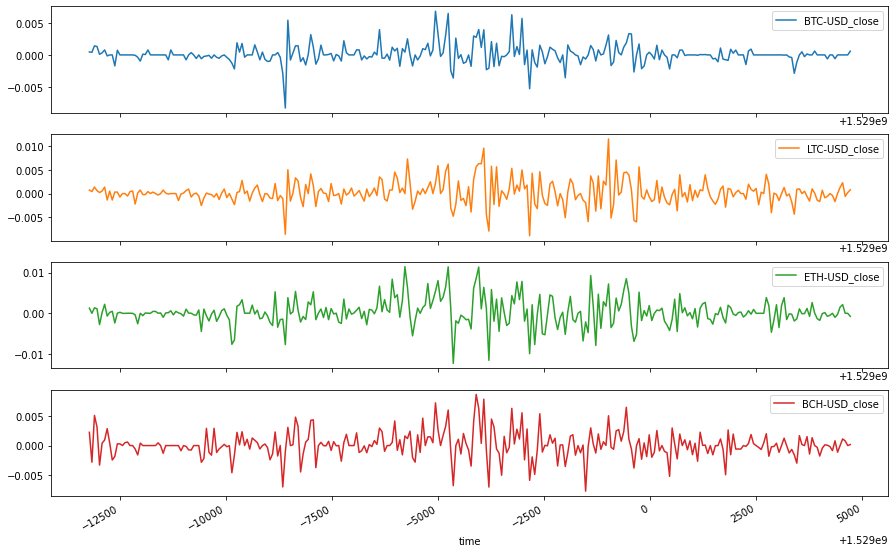

In [25]:

main_df = main_df.pct_change().copy()  #!!!
main_df[300:600].plot(subplots=True)
main_df = main_df[1:]
plt.show()


## Splitting data
It is common to split datasets into 3 parts. One is called training set and is uset for training our models. Another part is called validation set and after trainig we evaluate our model using this set and eventually change our model settings. After our model is done we will chceck results on thirs set which is calles test set. This last set is supposed to be uknown for our model so it should behave like "real world" data. We should pick model which does the best job with test set.

I will split main df into 3 parts with this ratio: (70%, 20%, 10%) train, validation, test.

In [26]:
def split_dataset(df):
    
    """
    Function returns train, validation and test dataframes. In ratio 70:20:10.

    Parameters
    ----------
    df: DataFrame
        DataFrame we would like to split

    Returns
    ----------
    Three dataframes.
    """
    
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    return train_df, val_df, test_df

In [27]:
#column_indices = {name: i for i, name in enumerate(df.columns)}
num_features = main_df.shape[1]

In [28]:
train_df_d, val_df_d, test_df_d = split_dataset(main_df)

In [29]:
train_df_my, val_df_my, test_df_my = split_dataset(my_df)

## Normalizing data
Our model could work even without normalizing, but it improves training ability and performance. My data has different scales, for that reason I need to normalize it.

##### Z-score

In [30]:

from sklearn.preprocessing import StandardScaler
scaler_d = StandardScaler()  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

train_df_d = pd.DataFrame(scaler_d.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler_d.transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler_d.transform(test_df_d),columns = test_df_d.columns)


scaler_my = StandardScaler()

train_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)
""" 
scaler_my = StandardScaler()

train_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)
"""

' \nscaler_my = StandardScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)\n'

##### Min-max scaler.

In [31]:
"""
from sklearn.preprocessing import MinMaxScaler


scaler_d_min_max = MinMaxScaler()

train_df_d = pd.DataFrame(scaler_d_min_max.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler_d_min_max.transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler_d_min_max.transform(test_df_d),columns = test_df_d.columns)


scaler_my_min_max = MinMaxScaler()

train_df_my = pd.DataFrame(scaler_my_min_max.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my_min_max.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my_min_max.transform(test_df_my),columns = test_df_my.columns)
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\n\n\nscaler_d_min_max = MinMaxScaler()\n\ntrain_df_d = pd.DataFrame(scaler_d_min_max.fit_transform(train_df_d),columns = train_df_d.columns)\nval_df_d = pd.DataFrame(scaler_d_min_max.transform(val_df_d),columns = val_df_d.columns)\ntest_df_d = pd.DataFrame(scaler_d_min_max.transform(test_df_d),columns = test_df_d.columns)\n\n\nscaler_my_min_max = MinMaxScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my_min_max.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my_min_max.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my_min_max.transform(test_df_my),columns = test_df_my.columns)\n'

### Data windowing

Models will make predictions using part of data called windows. 


In [32]:
class WindowGenerator():
    
    """
    Moving window class. Contains needed dataframes for training. 

    Parameters
    ----------
    input_width: int
        Dataframe we would like to split.
        
    input_width: int
        Width of window part model is supposed to predict.
        
    shift: int
        Shift between input and label.
        
    train_df: DataFrame
        Training dataframe
        
    val_df: DataFrame
        Validation dataframe
        
    test_df: DataFrame
        Test dataframe
    
    label_columns: 
        label column indices
    """
    
    
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        # This part takes arguemntes and calculate window size
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        

        # Window size is equal to input width and shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) # slice(0, i_w, None)
        
        # np.arange(5) -> array([0, 1, 2, 3, 4])
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Code below splits data inside window class into inputs and labels.
Inputs are data from which our model is supposed to predict label, 
which is the actual correct value.

In [33]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :] 
    # (whole, input_slice, whole): (3, 12, 4) -> i_s=5 (3,5,4)
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [34]:
w2 = WindowGenerator(input_width=24, label_width=1, shift=2,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d, label_columns=['BTC-USD_close'])
w2


Total window size: 26
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [25]
Label column name(s): ['BTC-USD_close']

In [35]:
w2

Total window size: 26
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [25]
Label column name(s): ['BTC-USD_close']

In [36]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df_d[:w2.total_window_size]),
                           np.array(train_df_d[100:100+w2.total_window_size]),
                           np.array(train_df_d[200:200+w2.total_window_size])])

In [37]:
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 26, 4)
Inputs shape: (3, 24, 4)
labels shape: (3, 1, 1)


Simple vizualization of the split window with function plot().

In [38]:
w2.example = example_inputs, example_labels

In [39]:
def plot(self, model=None, plot_col=RATIO_TO_PREDICT+'_close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs) # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-tensorflow
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
        
    plt.xlabel('Time [min]')

WindowGenerator.plot = plot

In [40]:
def plot_input_data(self,  model=None):
    inputs, labels = self.example
    
    print(inputs)
    plot(inputs)
    
WindowGenerator.plot_input_data = plot_input_data

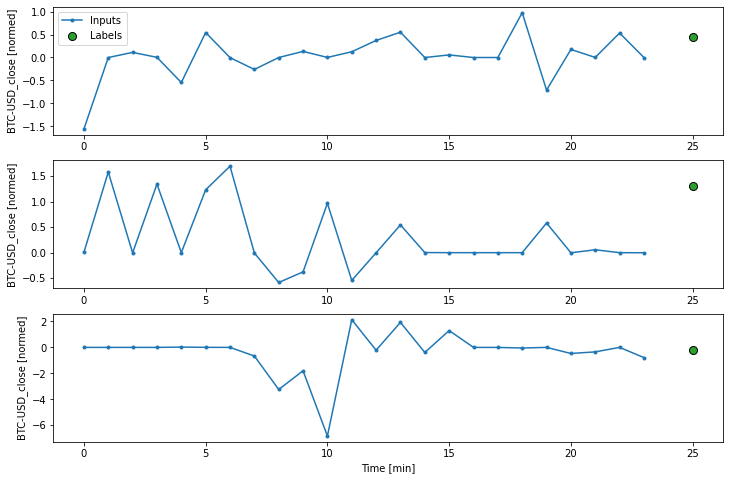

In [41]:
w2.plot()

#### Create dataset

Function below takes dataframe and converts it to tf.data.Dataset with (input_window, label_window) pairs.
First, we convert dataframe to np.array and then timeseries_dataset_from_array function converts it to dataset. 

In [42]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32) # convert data to np.array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32)
      # very useful function which converts data to dataset (input_window, label_window) from array

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


In [43]:
@property  # https://www.python-course.eu/python3_properties.php
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#### Define wide window

In [44]:
wide_window_d = WindowGenerator(
    input_width=24, label_width=24, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])

In [45]:
wide_window_my = WindowGenerator(
    input_width=24, label_width=24, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_my,val_df = val_df_my, test_df = test_df_my,label_columns=[RATIO_TO_PREDICT+'_close'])

In [46]:
wide_window_my.example[0].shape 

TensorShape([32, 24, 4])

#### To compare prediction performances

In [47]:
val_performance = {}
performance = {}

## Models

MyModel class to make working with models easier. 

In [115]:
from tensorflow.keras.models import load_model

class MyModel():
    
    def __init__(self, model):
        self.model = model
        
    def load_model(self, dir_name):
        self.model = load_model(dir_name)
    
    def eval_mod(self, window, verbose):
        res = self.model.evaluate(window, verbose=verbose)
        print("Loss:", res[0], "MAE:", res[1])
        
    def save_model(self, name):
        self.model.save("models_pct\\models_28_04_2021\\"+ name +".model")
        
    def retrain_model(self, window, patience, epochs):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
        history = self.model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])
        self.history = history
        
    def compile_and_fit(self, window, patience=3, epochs=120):

        ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min', restore_best_weights=True)
        
        # https://github.com/Jaewan-Yun/optimizer-visualization
        # https://www.tensorflow.org/api_docs/python/tf/keras/Model
        opt = tf.optimizers.Adam(learning_rate=0.02)
        
        self.model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=opt,
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = self.model.fit(window.train, epochs=epochs,
                          validation_data=window.val,
                          callbacks=[early_stopping])
        return history


In [49]:
""" 
Ftrl(
    learning_rate=0.01, learning_rate_power=-0.5, initial_accumulator_value=0.1,
    l1_regularization_strength=0.02, l2_regularization_strength=0.02,
    name='Ftrl', l2_shrinkage_regularization_strength=0.02, beta=0.5)
"""

" \nFtrl(\n    learning_rate=0.01, learning_rate_power=-0.5, initial_accumulator_value=0.1,\n    l1_regularization_strength=0.02, l2_regularization_strength=0.02,\n    name='Ftrl', l2_shrinkage_regularization_strength=0.02, beta=0.5)\n"

#### Training procedure
Because we will train more models let's create function which compiles and train desired model.

To plot learning process there is a function below.

In [50]:
MAX_EPOCHS = 120

def compile_and_fit(model, window, patience=3):

    ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min', restore_best_weights=True)

    # https://github.com/Jaewan-Yun/optimizer-visualization
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model

    
    model.compile(loss=tf.losses.LogCosh(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [51]:
def plot_loss(history, graph_param):
    plt.plot(history.history[str(graph_param)], label=str(graph_param))
    plt.plot(history.history['val_'+ str(graph_param)], label='val_' + str(graph_param))
    plt.xlabel('Epoch')
    plt.ylabel(graph_param)
    plt.legend()
    plt.grid(True)

To save model I created function below.

In [52]:
def save_model(model, name):
    model.save("models_21_03_2021\\"+ name +".model")
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#save
    """
    save(filepath, overwrite=True, include_optimizer=True, save_format=None,signatures=None, options=None)
    """

In [53]:
p

NameError: name 'p' is not defined

### Recurrent neural network (LSTM)

[batch, timesteps, feature] 3D input

In [116]:
act = "tanh"
recurrent_act = "sigmoid"

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(units=1)
])

In [117]:
lstm = MyModel(lstm_model)

In [118]:
history = lstm.compile_and_fit(wide_window_d)

Epoch 1/120
1318/1318 [==============================] - 15s 9ms/step - loss: 0.9742 - mean_absolute_error: 0.4501 - val_loss: 1.3287 - val_mean_absolute_error: 0.6024
Epoch 2/120
1318/1318 [==============================] - 12s 9ms/step - loss: 0.8702 - mean_absolute_error: 0.4445 - val_loss: 1.3698 - val_mean_absolute_error: 0.6037
Epoch 3/120
1318/1318 [==============================] - 12s 9ms/step - loss: 0.7624 - mean_absolute_error: 0.4328 - val_loss: 1.3953 - val_mean_absolute_error: 0.6190
Epoch 4/120
1318/1318 [==============================] - 12s 9ms/step - loss: 0.6980 - mean_absolute_error: 0.4251 - val_loss: 1.3973 - val_mean_absolute_error: 0.6190


In [119]:
val_performance['LSTM'] = lstm.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM'] = lstm.eval_mod(wide_window_d.test, verbose=1)

376/376 [==============================] - 1s 3ms/step - loss: 1.3287 - mean_absolute_error: 0.6024
Loss: 1.3287447690963745 MAE: 0.6024301052093506
188/188 [==============================] - 1s 3ms/step - loss: 1.0096 - mean_absolute_error: 0.4776
Loss: 1.009570598602295 MAE: 0.47762826085090637


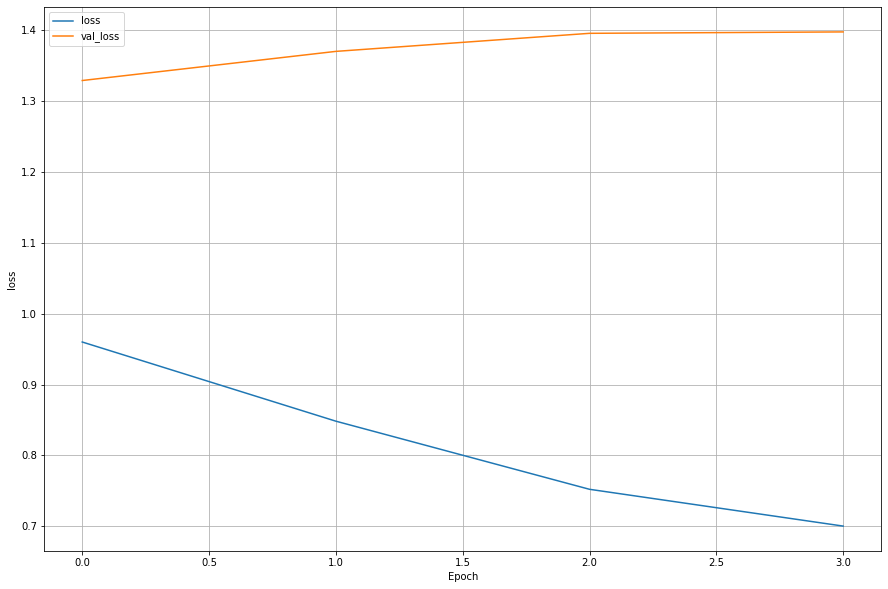

In [120]:
plot_loss(history, 'loss')

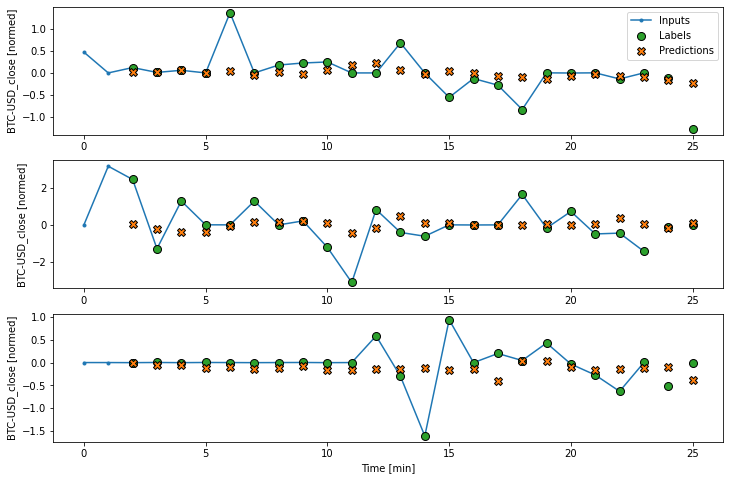

In [121]:
wide_window_d.plot(lstm.model)

In [122]:
lstm.save_model("lstm")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\lstm.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\lstm.model\assets


#### Loading model

In [123]:
lstm.model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 24, 32)            4736      
_________________________________________________________________
lstm_17 (LSTM)               (None, 24, 32)            8320      
_________________________________________________________________
dense_8 (Dense)              (None, 24, 1)             33        
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


### Recurrent neural network (LSTM - bidirectional)

Parameters from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [124]:
lstm_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    #tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [125]:
lstm_bidi = MyModel(lstm_model_bidirectional)

In [126]:
history = lstm_bidi.compile_and_fit(wide_window_d)

Epoch 1/120
1318/1318 [==============================] - 27s 17ms/step - loss: 0.2163 - mean_absolute_error: 0.1656 - val_loss: 0.1298 - val_mean_absolute_error: 0.1049
Epoch 2/120
1318/1318 [==============================] - 22s 16ms/step - loss: 0.0939 - mean_absolute_error: 0.0837 - val_loss: 0.1976 - val_mean_absolute_error: 0.1689
Epoch 3/120
1318/1318 [==============================] - 22s 16ms/step - loss: 0.1007 - mean_absolute_error: 0.0900 - val_loss: 0.1198 - val_mean_absolute_error: 0.0824
Epoch 4/120
1318/1318 [==============================] - 22s 16ms/step - loss: 0.0880 - mean_absolute_error: 0.0718 - val_loss: 0.1301 - val_mean_absolute_error: 0.1063
Epoch 5/120
1318/1318 [==============================] - 22s 16ms/step - loss: 0.0882 - mean_absolute_error: 0.0740 - val_loss: 0.1166 - val_mean_absolute_error: 0.0914
Epoch 6/120
1318/1318 [==============================] - 22s 16ms/step - loss: 0.0855 - mean_absolute_error: 0.0675 - val_loss: 0.1200 - val_mean_absolute_

In [127]:
val_performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.test, verbose=1)

376/376 [==============================] - 2s 6ms/step - loss: 0.1166 - mean_absolute_error: 0.0914
Loss: 0.11660131812095642 MAE: 0.09138168394565582
188/188 [==============================] - 1s 6ms/step - loss: 0.0852 - mean_absolute_error: 0.0784
Loss: 0.08517476171255112 MAE: 0.07838226854801178


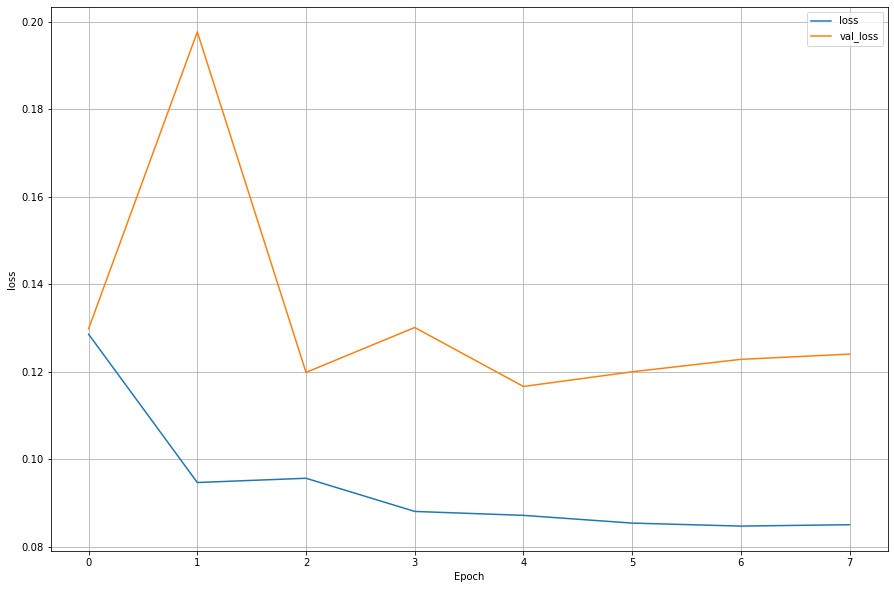

In [128]:
plot_loss(history, 'loss')

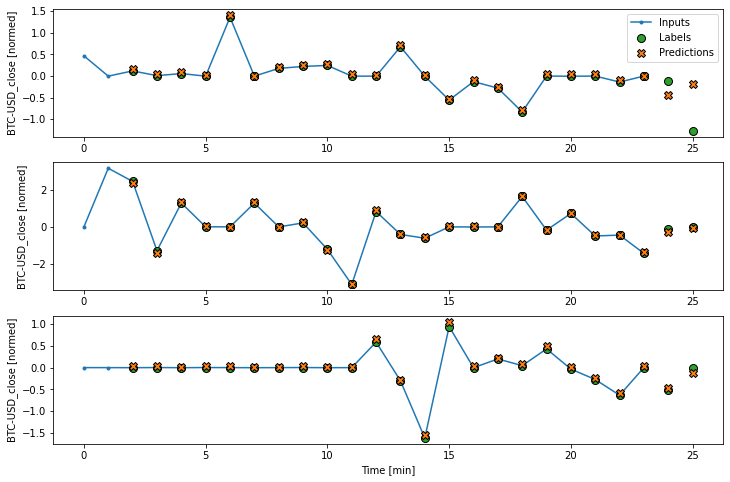

In [129]:
wide_window_d.plot(lstm_bidi.model)

In [130]:
lstm_bidi.save_model("l_bidi")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\l_bidi.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\l_bidi.model\assets


### Recurrent neural network (GRU)

Parameters from: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [131]:
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    #tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])


In [132]:
gru = MyModel(gru_model)

In [133]:
history = gru.compile_and_fit(wide_window_d)

Epoch 1/120
1318/1318 [==============================] - 14s 10ms/step - loss: 0.9870 - mean_absolute_error: 0.4518 - val_loss: 1.2984 - val_mean_absolute_error: 0.5862
Epoch 2/120
1318/1318 [==============================] - 12s 9ms/step - loss: 0.9907 - mean_absolute_error: 0.4500 - val_loss: 1.2944 - val_mean_absolute_error: 0.5889
Epoch 3/120
1318/1318 [==============================] - 12s 9ms/step - loss: 0.9852 - mean_absolute_error: 0.4508 - val_loss: 1.2931 - val_mean_absolute_error: 0.5815
Epoch 4/120
1318/1318 [==============================] - 12s 9ms/step - loss: 0.9796 - mean_absolute_error: 0.4493 - val_loss: 1.2934 - val_mean_absolute_error: 0.5881
Epoch 5/120
1318/1318 [==============================] - 12s 9ms/step - loss: 0.9800 - mean_absolute_error: 0.4471 - val_loss: 1.2920 - val_mean_absolute_error: 0.5784
Epoch 6/120
1318/1318 [==============================] - 12s 9ms/step - loss: 0.9864 - mean_absolute_error: 0.4470 - val_loss: 1.2936 - val_mean_absolute_error

In [134]:
val_performance['GRU'] = gru.eval_mod(wide_window_d.val, verbose=1)
performance['GRU'] = gru.eval_mod(wide_window_d.test, verbose=1)

376/376 [==============================] - 1s 2ms/step - loss: 1.2910 - mean_absolute_error: 0.5853
Loss: 1.2909730672836304 MAE: 0.5852590799331665
188/188 [==============================] - 0s 2ms/step - loss: 0.9774 - mean_absolute_error: 0.4578
Loss: 0.977442741394043 MAE: 0.45784297585487366


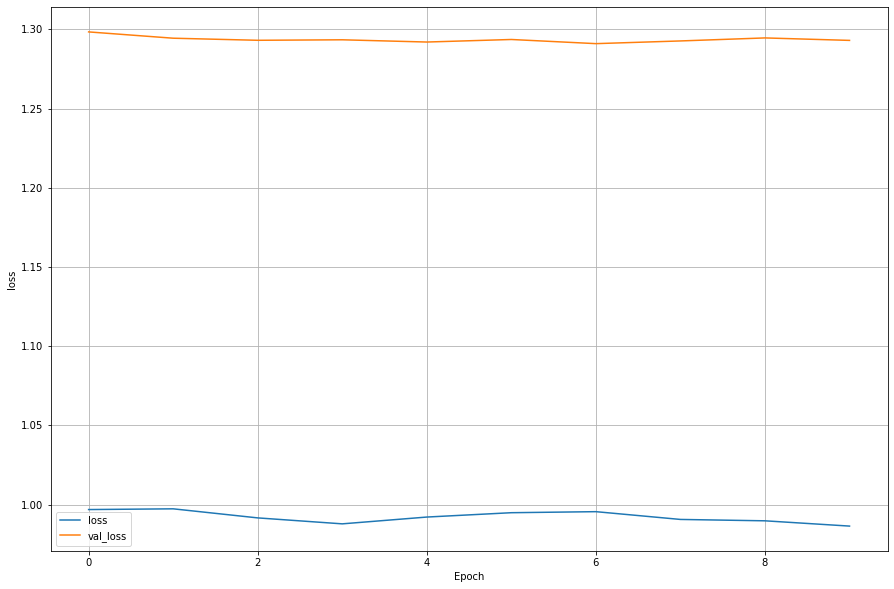

In [135]:
plot_loss(history, 'loss')

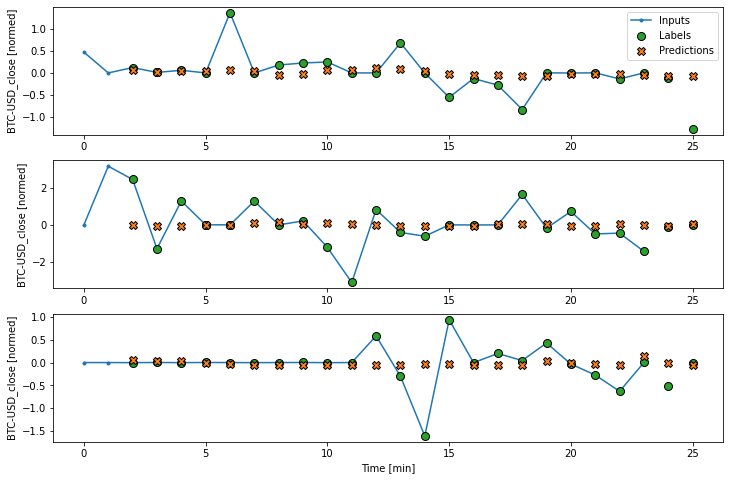

In [136]:
wide_window_d.plot(gru.model)

In [137]:
gru.save_model("gru")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\gru.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\gru.model\assets


### Recurrent neural network (GRU - bidirectional)

In [138]:
gru_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [139]:
gru_bidi = MyModel(gru_model_bidirectional)

In [140]:
history = gru_bidi.compile_and_fit(wide_window_d)

Epoch 1/120
1318/1318 [==============================] - 29s 20ms/step - loss: 0.2022 - mean_absolute_error: 0.1833 - val_loss: 0.1401 - val_mean_absolute_error: 0.1082
Epoch 2/120
1318/1318 [==============================] - 26s 20ms/step - loss: 0.1270 - mean_absolute_error: 0.1277 - val_loss: 0.1402 - val_mean_absolute_error: 0.1144
Epoch 3/120
1318/1318 [==============================] - 26s 20ms/step - loss: 0.1156 - mean_absolute_error: 0.1141 - val_loss: 0.1291 - val_mean_absolute_error: 0.0924
Epoch 4/120
1318/1318 [==============================] - 26s 20ms/step - loss: 0.1056 - mean_absolute_error: 0.1019 - val_loss: 0.1313 - val_mean_absolute_error: 0.1015
Epoch 5/120
1318/1318 [==============================] - 26s 20ms/step - loss: 0.0947 - mean_absolute_error: 0.0888 - val_loss: 0.1444 - val_mean_absolute_error: 0.1247
Epoch 6/120
1318/1318 [==============================] - 26s 20ms/step - loss: 0.1026 - mean_absolute_error: 0.1017 - val_loss: 0.1450 - val_mean_absolute_

In [141]:
val_performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.test, verbose=1)

376/376 [==============================] - 2s 5ms/step - loss: 0.1291 - mean_absolute_error: 0.0924
Loss: 0.1290898621082306 MAE: 0.09244154393672943
188/188 [==============================] - ETA: 0s - loss: 0.0926 - mean_absolute_error: 0.078 - 1s 5ms/step - loss: 0.0936 - mean_absolute_error: 0.0790
Loss: 0.09361742436885834 MAE: 0.07895251363515854


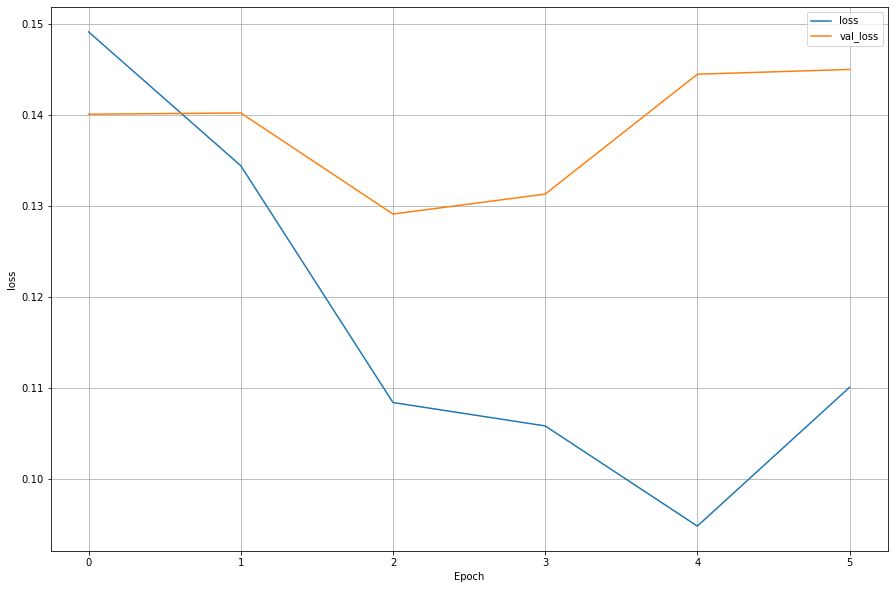

In [142]:
plot_loss(history, 'loss')

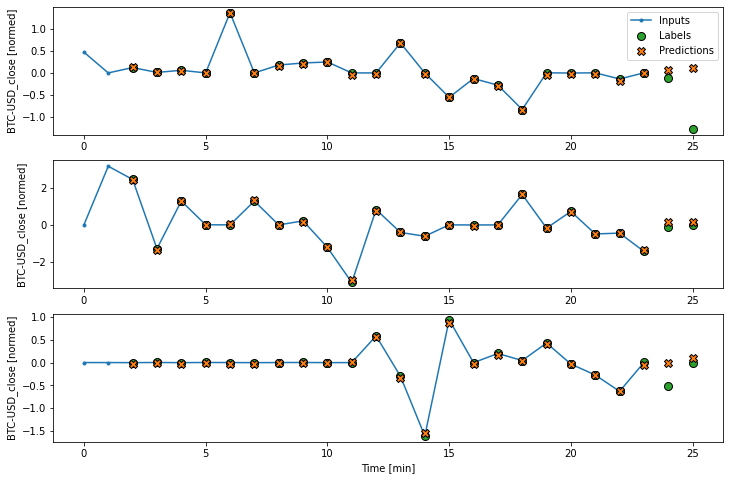

In [143]:
wide_window_d.plot(gru_bidi.model)

In [144]:
gru_bidi.save_model("g_bidi")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\g_bidi.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\g_bidi.model\assets


### Performance

In [145]:
"""
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]


plt.ylabel('mean_absolute_error [BTC-USD, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
"""

"\nx = np.arange(len(performance))\nwidth = 0.3\nmetric_name = 'mean_absolute_error'\nmetric_index = lstm_model.metrics_names.index('mean_absolute_error')\nval_mae = [v[metric_index] for v in val_performance.values()]\ntest_mae = [v[metric_index] for v in performance.values()]\n\n\nplt.ylabel('mean_absolute_error [BTC-USD, normalized]')\nplt.bar(x - 0.17, val_mae, width, label='Validation')\nplt.bar(x + 0.17, test_mae, width, label='Test')\nplt.xticks(ticks=x, labels=performance.keys(),\n           rotation=45)\n_ = plt.legend()\n"

In [146]:
"""
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')
"""

"\nfor name, value in performance.items():\n    print(f'{name:12s}: {value[1]:0.4f}')\n"

## Single shot models
The entire sequence prediction in a single step.

24 min to the future with 2 min to the future

In [147]:
OUT_STEPS = 1
wide_window_d_single = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])

wide_window_my_single = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_my,val_df = val_df_my, test_df = test_df_my,label_columns=[RATIO_TO_PREDICT+'_close'])



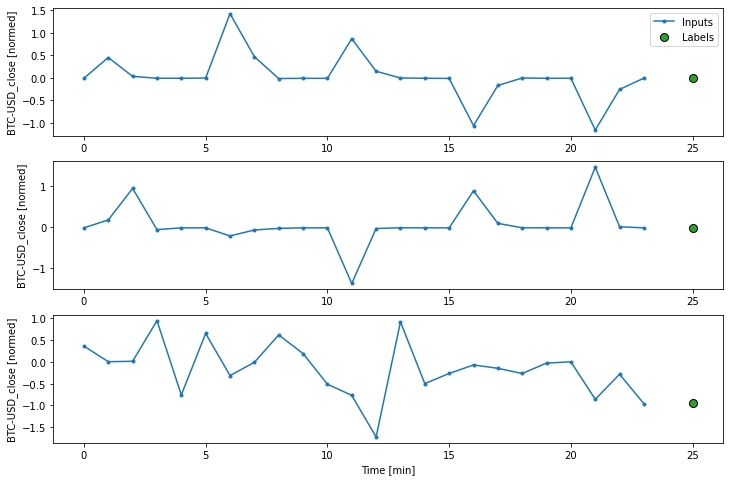

In [148]:
wide_window_my_single.plot()

In [149]:
single_val_performance = {}
single_performance = {}

### LSTM single shot

In [150]:
lstm_model_single = tf.keras.Sequential([
    
    tf.keras.layers.LSTM(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32, activation=act, recurrent_activation=recurrent_act),
    #tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [151]:
lstm_single = MyModel(lstm_model_single)

In [152]:
history = lstm_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
1318/1318 [==============================] - 21s 13ms/step - loss: 0.9781 - mean_absolute_error: 0.4430 - val_loss: 1.2910 - val_mean_absolute_error: 0.5767
Epoch 2/120
1318/1318 [==============================] - 16s 12ms/step - loss: 0.9810 - mean_absolute_error: 0.4427 - val_loss: 1.2911 - val_mean_absolute_error: 0.5811
Epoch 3/120
1318/1318 [==============================] - 17s 13ms/step - loss: 0.9767 - mean_absolute_error: 0.4437 - val_loss: 1.2925 - val_mean_absolute_error: 0.5849
Epoch 4/120
1318/1318 [==============================] - 17s 13ms/step - loss: 0.9754 - mean_absolute_error: 0.4465 - val_loss: 1.2980 - val_mean_absolute_error: 0.5914


In [153]:
single_val_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.test, verbose=1)

376/376 [==============================] - 1s 3ms/step - loss: 1.2910 - mean_absolute_error: 0.5767
Loss: 1.2909635305404663 MAE: 0.5767406225204468
188/188 [==============================] - 1s 3ms/step - loss: 0.9766 - mean_absolute_error: 0.4475
Loss: 0.9766150712966919 MAE: 0.4475080072879791


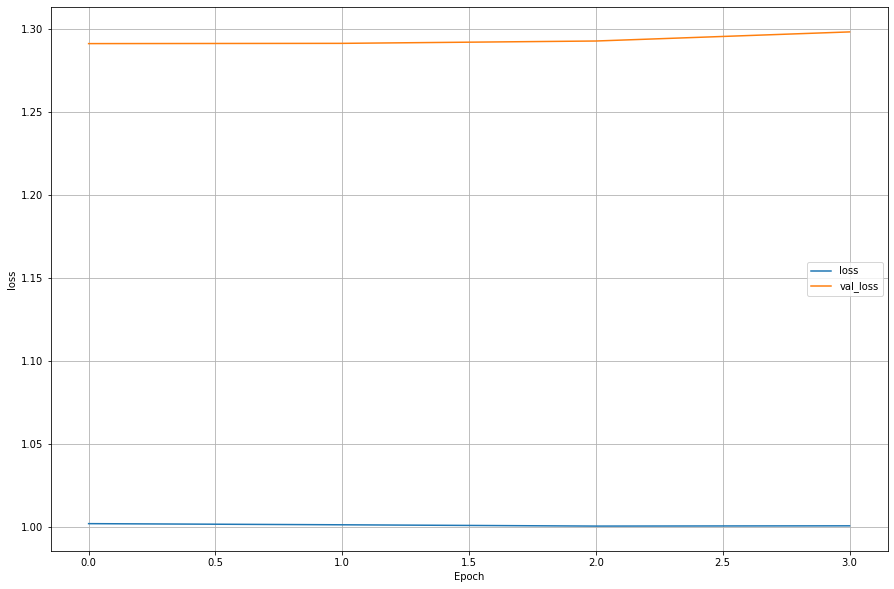

In [154]:
plot_loss(history, 'loss')

In [155]:
lstm_single.save_model("lstm_s")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\lstm_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\lstm_s.model\assets


### LSTM Bidirectional single shot

In [156]:
lstm_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation=act, recurrent_activation=recurrent_act)),
    #tf.keras.layers.Dense(32, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [157]:
lstm_bidi_single = MyModel(lstm_model_bidirectional_single)

In [158]:
history = lstm_bidi_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
1318/1318 [==============================] - 39s 27ms/step - loss: 0.9665 - mean_absolute_error: 0.4545 - val_loss: 1.2914 - val_mean_absolute_error: 0.5717
Epoch 2/120
1318/1318 [==============================] - 34s 26ms/step - loss: 0.9668 - mean_absolute_error: 0.4432 - val_loss: 1.2908 - val_mean_absolute_error: 0.5789
Epoch 3/120
1318/1318 [==============================] - 34s 26ms/step - loss: 0.9589 - mean_absolute_error: 0.4443 - val_loss: 1.3005 - val_mean_absolute_error: 0.6091
Epoch 4/120
1318/1318 [==============================] - 34s 26ms/step - loss: 0.9602 - mean_absolute_error: 0.4450 - val_loss: 1.2916 - val_mean_absolute_error: 0.5848
Epoch 5/120
1318/1318 [==============================] - 34s 26ms/step - loss: 0.9555 - mean_absolute_error: 0.4423 - val_loss: 1.2963 - val_mean_absolute_error: 0.6004


In [159]:
single_val_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

376/376 [==============================] - 3s 9ms/step - loss: 1.2908 - mean_absolute_error: 0.5789A: 0s - loss: 1.2895 - mean_absolute_error: 0.57
Loss: 1.2907707691192627 MAE: 0.578919529914856
188/188 [==============================] - 2s 8ms/step - loss: 0.9785 - mean_absolute_error: 0.4507
Loss: 0.9784537553787231 MAE: 0.45069238543510437


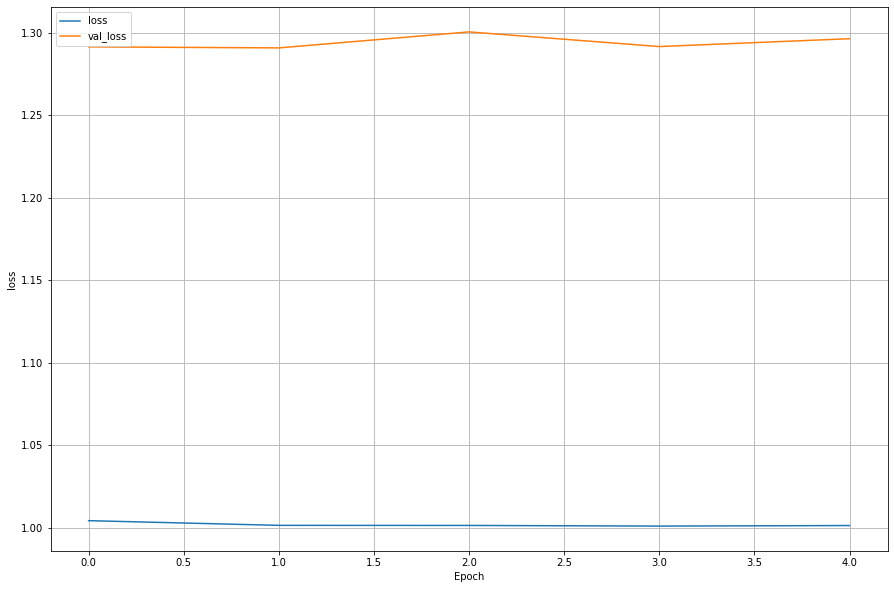

In [160]:
plot_loss(history, 'loss')

In [161]:
lstm_bidi_single.save_model("l_b_s")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\l_b_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\l_b_s.model\assets


### GRU single shot

In [162]:
gru_model_single = tf.keras.models.Sequential([

    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32, activation=act, recurrent_activation=recurrent_act),
    #tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [163]:
gru_single = MyModel(gru_model_single)

In [164]:
history = gru_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
1318/1318 [==============================] - 15s 10ms/step - loss: 1.0721 - mean_absolute_error: 0.4930 - val_loss: 1.2931 - val_mean_absolute_error: 0.5696
Epoch 2/120
1318/1318 [==============================] - 13s 10ms/step - loss: 1.0597 - mean_absolute_error: 0.4928 - val_loss: 1.3133 - val_mean_absolute_error: 0.6185
Epoch 3/120
1318/1318 [==============================] - 13s 10ms/step - loss: 1.0644 - mean_absolute_error: 0.5007 - val_loss: 1.3081 - val_mean_absolute_error: 0.6208
Epoch 4/120
1318/1318 [==============================] - 13s 10ms/step - loss: 1.0623 - mean_absolute_error: 0.5048 - val_loss: 1.3000 - val_mean_absolute_error: 0.6052


In [165]:
single_val_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.test, verbose=1)

376/376 [==============================] - 1s 2ms/step - loss: 1.2931 - mean_absolute_error: 0.5696
Loss: 1.2930803298950195 MAE: 0.5695917010307312
188/188 [==============================] - 0s 2ms/step - loss: 0.9796 - mean_absolute_error: 0.4388
Loss: 0.9796121716499329 MAE: 0.4387539029121399


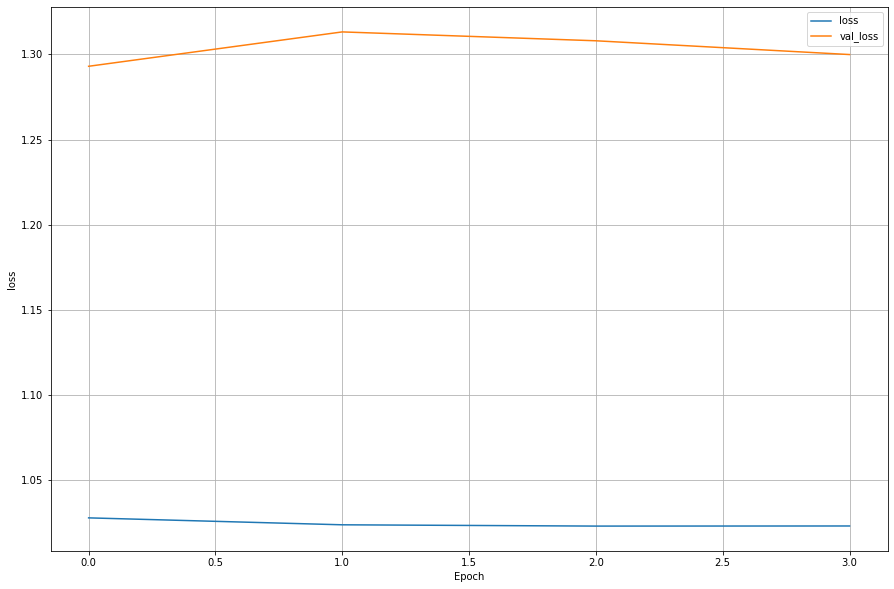

In [166]:
plot_loss(history, 'loss')

In [167]:
gru_single.save_model("gru_s")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\gru_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\gru_s.model\assets


### GRU Bidirectional single shot

In [168]:
gru_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, activation=act, recurrent_activation=recurrent_act)),
    #tf.keras.layers.Dense(32, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [169]:
gru_bidi_single = MyModel(gru_model_bidirectional_single)

In [170]:
history = gru_bidi_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
1318/1318 [==============================] - 28s 19ms/step - loss: 1.0529 - mean_absolute_error: 0.5050 - val_loss: 1.3423 - val_mean_absolute_error: 0.6553
Epoch 2/120
1318/1318 [==============================] - 25s 19ms/step - loss: 1.0350 - mean_absolute_error: 0.4974 - val_loss: 1.2930 - val_mean_absolute_error: 0.5685
Epoch 3/120
1318/1318 [==============================] - 25s 19ms/step - loss: 1.0185 - mean_absolute_error: 0.5022 - val_loss: 1.3290 - val_mean_absolute_error: 0.6413
Epoch 4/120
1318/1318 [==============================] - 25s 19ms/step - loss: 1.0513 - mean_absolute_error: 0.5057 - val_loss: 1.4115 - val_mean_absolute_error: 0.7307
Epoch 5/120
1318/1318 [==============================] - 25s 19ms/step - loss: 1.0466 - mean_absolute_error: 0.5058 - val_loss: 1.3529 - val_mean_absolute_error: 0.6694


In [171]:
single_val_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

376/376 [==============================] - 2s 5ms/step - loss: 1.2930 - mean_absolute_error: 0.5685
Loss: 1.2929515838623047 MAE: 0.5685073733329773
188/188 [==============================] - 1s 5ms/step - loss: 0.9790 - mean_absolute_error: 0.4365
Loss: 0.9789758324623108 MAE: 0.43654748797416687


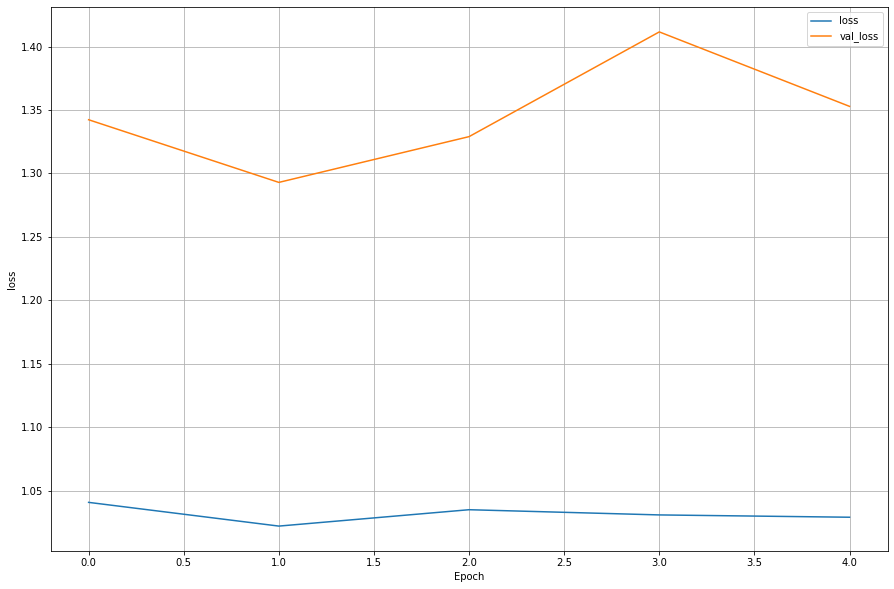

In [172]:
plot_loss(history, 'loss')

In [173]:
gru_bidi_single.save_model("g_b_s")

INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\g_b_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_28_04_2021\g_b_s.model\assets


### Autoregressive model

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

In [ ]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

In [175]:
print("kez")

kez


In [ ]:
history = compile_and_fit(feedback_model, multi_window)

In [ ]:
IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model_single.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

### Evaluating loaded models

In [ ]:
model.summary()

In [634]:
path = "models_28_04_2021"

In [635]:
lstm = load_model("models_pct/"+path+"/lstm.model")
lstm_bidi = load_model("models_pct/"+path+"/l_bidi.model")
gru = load_model("models_pct/"+path+"/gru.model")
gru_bidi = load_model("models_pct/"+path+"/g_bidi.model")

## Single shot 
lstm_s = load_model("models_pct/"+path+"/lstm_s.model")
lstm_bidi_s = load_model("models_pct/"+path+"/l_b_s.model")
gru_s = load_model("models_pct/"+path+"/gru_s.model")
gru_bidi_s = load_model("models_pct/"+path+"/g_b_s.model")

In [636]:
loaded_model_lstm = MyModel(lstm)

In [637]:
loaded_model_lstm.eval_mod(wide_window_d.val, 0)

Loss: 1.3287451267242432 MAE: 0.6024302840232849


In [638]:
loaded_model_lstm.eval_mod(wide_window_d.test, 0)

Loss: 1.009570598602295 MAE: 0.4776283800601959


In [639]:
loaded_model_lstm.eval_mod(wide_window_my.test, 0)

Loss: 4.973471641540527 MAE: 1.0257470607757568


In [640]:
loaded_model_lstm_b = MyModel(lstm_bidi)

In [641]:
loaded_model_lstm_b.eval_mod(wide_window_d.val, 0)

Loss: 0.11660131812095642 MAE: 0.09138168394565582


In [642]:
loaded_model_lstm_b.eval_mod(wide_window_d.test, 0)

Loss: 0.08517477661371231 MAE: 0.07838223874568939


In [643]:
loaded_model_lstm_b.eval_mod(wide_window_my.test, 0)

Loss: 0.4644470810890198 MAE: 0.15756385028362274


In [644]:
loaded_model_gru = MyModel(gru)

In [645]:
loaded_model_gru.eval_mod(wide_window_d.val, 0)

Loss: 1.2909733057022095 MAE: 0.5852593779563904


In [646]:
loaded_model_gru.eval_mod(wide_window_d.test, 0)

Loss: 0.9774430990219116 MAE: 0.4578428566455841


In [647]:
loaded_model_gru.eval_mod(wide_window_my.test, 0)

Loss: 4.9153733253479 MAE: 0.979810893535614


In [648]:
loaded_model_gru_bidi = MyModel(gru_bidi)

In [649]:
loaded_model_gru_bidi.eval_mod(wide_window_d.val, 0)

Loss: 0.1290898621082306 MAE: 0.09244148433208466


In [650]:
loaded_model_gru_bidi.eval_mod(wide_window_d.test, 0)

Loss: 0.09361741691827774 MAE: 0.07895249873399734


In [651]:
loaded_model_gru_bidi.eval_mod(wide_window_my.test, 0)

Loss: 0.5038602948188782 MAE: 0.20880237221717834


#### Eval single

In [652]:
loaded_model_lstm_s = MyModel(lstm_s)

In [653]:
loaded_model_lstm_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.290962815284729 MAE: 0.5767405033111572


In [654]:
loaded_model_lstm_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9766148924827576 MAE: 0.4475078880786896


In [655]:
loaded_model_lstm_s.eval_mod(wide_window_my_single.test, 0)

Loss: 4.906465530395508 MAE: 0.9725013971328735


In [682]:
lstm_s.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 24, 32)            4736      
_________________________________________________________________
lstm_21 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


In [656]:
loaded_model_lstm_b_s = MyModel(lstm_bidi_s)

In [657]:
loaded_model_lstm_b_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.290771245956421 MAE: 0.5789194703102112


In [658]:
loaded_model_lstm_b_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9784535765647888 MAE: 0.45069217681884766


In [659]:
loaded_model_lstm_b_s.eval_mod(wide_window_my_single.test, 0)

Loss: 4.906379699707031 MAE: 0.977116048336029


In [660]:
loaded_model_gru_s = MyModel(gru_s)

In [661]:
loaded_model_gru_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.2930803298950195 MAE: 0.569591760635376


In [662]:
loaded_model_gru_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9796124696731567 MAE: 0.43875381350517273


In [663]:
loaded_model_gru_s.eval_mod(wide_window_my_single.test, 0)

Loss: 4.908161640167236 MAE: 0.9602807760238647


In [664]:
loaded_model_gru_b_s = MyModel(gru_bidi_s)

In [665]:
loaded_model_gru_b_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.292952299118042 MAE: 0.5685072541236877


In [666]:
loaded_model_gru_b_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9789756536483765 MAE: 0.43654748797416687


In [667]:
loaded_model_gru_b_s.eval_mod(wide_window_my_single.test, 0)

Loss: 4.908663749694824 MAE: 0.9577218294143677
